### Deconvolves the BOLD-timeseries using a finite impulse response model.

Note that we first extract the mean timeseries from a mask, e.g., the STN

In [717]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sn
sn.set(style="ticks")

import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit

import sys
import os
import fir
import pickle as pkl

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Functions to generate mean timeseries within a mask

In [718]:
import numbers

def include(mask, threshold_percentile=.3):
    """ Creates binary mask out of probability mask + threshold """
    if not isinstance(mask, nib.Nifti1Image):
        if isinstance(mask, str):
            mask = nib.load(mask)
    
    dat = mask.get_data()
    if dat.max() > 1:
        # the mask is apparently scaled [0, 100] instead of [0, 1], so multiply threshold to compensate
        threshold_percentile = threshold_percentile * 100
    dat_include = np.array(dat > (threshold_percentile), dtype=float)
    
    img = nib.Nifti1Image(dat_include, mask.affine)
    return img

def create_single_timeseries(imgs, mask, mask_threshold=0.3, return_raw=True, tr=3., hp=1/128., zscore=True):
    """ Creates a single timeseries of multiple runs. Does:
    1. Creates a single mean timeseries within a ROI per run
    2. Highpass-filters the run
    3. z-scores the highpassed data.
    
    Betas of GLMs performed on z-scored timeseries can be interpreted as perc. signal change (need to check this to be sure)
    """
    sample_rate = 1/float(tr)
    
    masked_data = [masking.apply_mask(x, include(mask, mask_threshold)) for x in imgs]
    masked_data_mean = [x.mean(1) for x in masked_data]  # mean within mask here

    if return_raw:
        # no highpass or zscored required, so return raw
        return masked_data_mean
    
    highpassed_data = []
    for x in masked_data_mean:
        # High pass:
        if isinstance(hp, numbers.Number):
            hp_cof_sample = hp / (sample_rate / 2)
            bhp, ahp = sp.signal.butter(3, hp_cof_sample, btype='highpass')
            data_highpass = sp.signal.filtfilt(bhp, ahp, x)  # as a HP filter, this also demeans
        else:
            data_highpass = x
            
        if zscore:
            # get z-score for concatenation
            data_highpass = sp.stats.zscore(data_highpass)
        
        # add to list
        highpassed_data.append(data_highpass)

    return highpassed_data


### Functions to get event data

In [719]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def concat_event_data(subject_id, session, runs=(1,2,3), 
                      n_pulses_per_run=(343, 343, 343), tr=3,  # required for estimating deltas
                      bids_root='./data/deriv/fmriprep', 
                      event_types=('go_trial', 'successful_stop', 'failed_stop'),
                      get_jitters=True,
                      time_delta_between_runs=0):
    """ Concatenates event data to create a single DF for all events across 3 runs. """
    dfs = []
    for i, run in enumerate(runs):
        df = get_event_data(subject_id, session, run, event_types=event_types, get_jitters=get_jitters)
        final_time = df.iloc[-1]['onset']
        if i>0:
            df['onset'] += n_pulses_per_run[i-1]*tr*i + time_delta_between_runs*i  # additional seconds in between?
            df['response_time'] += n_pulses_per_run[i-1]*tr*i + time_delta_between_runs*i # additional seconds in between?
        dfs.append(df)
    df = pd.concat(dfs)
    return df

#concat_event_data('13', 'se')

### Wrappers to get functional time series

In [720]:
# Let's extract all mean timeseries first...
def get_func_file_names(sub, session, mask_name, pre_highpassed=False, zscore=False, denoised=False, echo_n=None):
    """ Gets filenames of functional data of a sub&session.
    
    Params
    -------
    pre_highpassed: bool
        Load data that are already highpass filtered?
    denoised (ME only): bool
        Load ME data that are denoised?
    echo_n (ME only): bool
        Load individual echo of ME data?
    zscore: bool
        Load z-scored data? (only used for cache name determination here)
        
    Returns
    -------
    cache_fn: str
        Name of cache file corresponding to current data
    bold_imgs: list of str
        List of paths to bold images of the three runs
    """
    
    if session == 'se':
        cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_%s.pkl' %(sub, mask_name))
        bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                     './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                     './data/deriv/fmriprep/sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub)
                    ]
    elif session == 'me':
        if denoised:
            cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_tedana-denoised_%s.pkl' %(sub, mask_name))
            bold_imgs = ['./tedana_denoising/TED.sub-%s_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub),
                         './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-2_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub),
                         './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-3_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32/dn_ts_OC.nii'%(sub)
                        ]
        else:
            if echo_n is None:
                # load combined ME data
                cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_me-optcomb_%s.pkl' %(sub, mask_name))
                bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-2_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-3_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub)
                            ]
            else:
                # load individual echo
                cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_me-echo-%d_%s.pkl' %(sub, echo_n, mask_name))
                bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-1_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-2_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub),
                             './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-3_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, echo_n, sub)
                            ]
    
    # check highpass, zscore options
    if pre_highpassed:
        bold_imgs = [x.replace('.nii.gz', '_hp.nii.gz') for x in bold_imgs]
        cache_fn = cache_fn.replace('.pkl', '_hp.pkl')
    if not zscore:
        cache_fn = cache_fn.replace('.pkl', '_nonzscored.pkl')
        
    return cache_fn, bold_imgs


def get_mean_ts(sub, session, mask_name, mask_threshold=1/3., zscore=False, pre_highpassed=False,
                denoised=False, echo_n=None, cache_only=False, overwrite_cache=False, verbose=False,
                truely_raw=False):
    """ Get mean timeseries within a mask of a sub, session, mask """
    
    if verbose:
        print(sub, end='...')
        
    # mask name
    mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)
    
    # filenames of functional data
    cache_fn, bold_imgs = get_func_file_names(sub=sub, session=session, mask_name=mask_name, 
                                              pre_highpassed=pre_highpassed, zscore=zscore,
                                              denoised=denoised, echo_n=echo_n)
    if os.path.exists(cache_fn) and not overwrite_cache:
        if verbose:
            print(' Reading from cache...', end='')
        with open(cache_fn, 'rb') as f:
            tmp = pkl.load(f)
    else:
        if cache_only:
            return None
        if (pre_highpassed and not zscore) or truely_raw:
            return_raw = True
        else:
            return_raw = False
            # returns "raw" data (no zscore, no highpass filtering)
        
        tmp = create_single_timeseries(bold_imgs, mask=mask_img, mask_threshold=mask_threshold, 
                                       zscore=zscore, return_raw=return_raw)
        with open(cache_fn, 'wb') as f:
            pkl.dump(tmp, f)
            
    return tmp

### Extract all timeseries beforehand
and save in cache

In [593]:
# Set-up
deconvolution_cache = './deconvolution_cache'
if not os.path.exists(deconvolution_cache):
    os.mkdir(deconvolution_cache)

# some settings for deconvolution
interval = 18  # BOLD response takes about ~18 sec
tr=3.
sample_rate = 1/tr

# define ROIs and corresponding thresholds
mask_threshold_dict = {
    'STN_L': 0.3,
    'M1_R': 0.3,
    'M1_L': 0.3,
    'STN_R': 0.3,
    'STR_L': 0.3,
    'STR_R': 0.3,
    'PreSMA_L': 0.3, # THIS DOES NOTHING (preSMA isnt a probabilitic map. This value is included here for compatibility)
    'PreSMA_R': 0.3, # THIS DOES NOTHING
    'ACC': 0.3,
    'rIFG': 0.3,
    'GPi_L': 0.3,
    'GPi_R': 0.3,
    'GPe_L': 0.3,
    'GPe_R': 0.3,
    'M1': 0.3,
}

# Define all subjects for which we have data
all_subs_se = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '13', '14', '15', '16', '17', '18']
all_subs_me = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '13', '14', '15', '16', '17', '18']
all_subs_me_denoised = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '13', '14', '15', '16', '17', '18']

# Functional data attributes: Return a zscored timeseries and/or use pre-highpassed data? (currently yes)
zscore = True
pre_highpassed = True

In [608]:
# do this multiprocessed to speed things up: It's quite some timeseries that need to be extracted in total
import re
import multiprocessing as mp
from functools import partial
import itertools
to_run = list(itertools.product(all_subs_se, ['me', 'se', 'me_denoised'], mask_threshold_dict.keys()))
n_procs = 10

def mp_helper(*args, **kwargs):
    """ Helper function that interprets arguments & passes correctly to get_mean_ts """
    sub = args[0][0]
    ses = args[0][1]
    mask_name = args[0][2]
    mask_threshold_dict = kwargs.pop('mask_threshold_dict')
    mask_threshold = mask_threshold_dict[mask_name]
    if ses == 'me_denoised':
        ses = 'me'
        denoised = True
    else:
        denoised = False
    
    regex = re.compile('me_e<?P(echo_n)\d+>')
    grpd = regex.match(ses)
    if grpd is not None:
        echo_n = grpd['echo_n']
        ses = 'me'
    else:
        echo_n = None
    
    if sub == '12' and ses == 'me':
        return 0
    
    get_mean_ts(sub=sub, session=ses, mask_name=mask_name, 
                mask_threshold=mask_threshold, 
                denoised=denoised,
                **kwargs)

# run in Pool
with mp.Pool(processes=n_procs) as p:
    results = p.map(partial(mp_helper, 
                            pre_highpassed=pre_highpassed, 
                            verbose=False, 
                            zscore=zscore, 
                            mask_threshold_dict=mask_threshold_dict),
                            to_run)

# FIR deconvolution

In [744]:
def renormalize(signal, target_signal):
    zscored_signal = sp.stats.zscore(signal)
    signal_rescaled = zscored_signal * target_signal.std() + target_signal.mean()
    return signal_rescaled
    
def combine_fds(fds, normalize_signal_against_first=True, as_pct_signal_change=False):
    """ Combines the FD-setup of multiple runs """
    from copy import deepcopy
    fd_out = deepcopy(fds[0])    
    if as_pct_signal_change:
        fd_out.resampled_signal[0] = fd_out.resampled_signal[0]/fd_out.resampled_signal[0].mean()*100-100

    if len(fds) > 1:
        for fd in fds[1:]:
            fd_out.resampled_signal_size += fd.resampled_signal_size
            fd_out.design_matrix = np.hstack([fd_out.design_matrix, fd.design_matrix])
            
            if normalize_signal_against_first:
                orig = fd.resampled_signal[0]  # timeseries of current fd
                target = fds[0].resampled_signal[0]  # timeseries of new fd
                fd.resampled_signal = renormalize(orig, target)[np.newaxis,]
            if as_pct_signal_change:
                fd.resampled_signal[0] = fd.resampled_signal[0]/fd.resampled_signal[0].mean()*100-100
            fd_out.resampled_signal = np.hstack([fd_out.resampled_signal, fd.resampled_signal])
            
            # add durations, duration indices, event time indicates
            for key, item in fd_out.durations.items():
                fd_out.durations[key] = np.hstack([fd_out.durations[key], fd.durations[key]])
                fd_out.duration_indices[key] = np.hstack([fd_out.duration_indices[key], fd.duration_indices[key]])
                fd_out.event_times_indices[key] = np.hstack([fd_out.event_times_indices[key], fd.event_times_indices[key]])
    return fd_out

In [722]:
def load_confounds(sub, ses):
    
    if ses == 'se':
        confds = pd.read_csv('./data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-se_task-stop_run-1_bold_confounds.tsv' %(sub, ses, sub, ses))
    else:
        confds = pd.read_csv('./data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-me_task-stop_run-1_echo-1_bold_confounds.tsv' %(sub, ses, sub, ses))
    
    return confds

In [723]:
def do_firdeconv(sub, ses, mask_name, denoised=False, pre_highpassed=True, cache_only=True, zscore=True,
                 single_fd=True):
    """ Function that performs the FIRDeconvolution for a single subject & session (across runs) """
    
    mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)
    func_timeseries = get_mean_ts(sub, session=ses, mask_name=mask_name, 
                                  pre_highpassed=pre_highpassed, denoised=denoised,
                                  cache_only=cache_only, zscore=zscore)
    if func_timeseries is None:
#         print('huh? Something went wrong')
#         print(sub)
#         print(ses)
#         print(mask_name)
        return None

    all_fds = []
    for run in range(1,4):
        all_events = get_event_data(sub, ses, run)
#         if mask_name in ['M1_L', 'M1_R']:
#             # use left/right responses
#             events = [np.array([x for x in all_events.loc[(all_events.response_direction=='response_right'), 'response_time'].tolist()]),
#                       np.array([x for x in all_events.loc[(all_events.response_direction=='response_left'), 'response_time'].tolist()])]

#             durations = {'response_right': np.array([0.1 for x in events[0]]),
#                          'response_left': np.array([0.1 for x in events[1]])}
#             event_names = ('response_right', 'response_left')
#         else:
        events = ([np.array([x for x in all_events.loc[(all_events.trial_type=='go_trial'), 'onset'].tolist()]),
                   np.array([x for x in all_events.loc[(all_events.trial_type=='successful_stop'), 'onset'].tolist()]),
                   np.array([x for x in all_events.loc[(all_events.trial_type=='failed_stop'), 'onset'].tolist()])
                   ])
        durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
                     'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
                     'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
                     }
        event_names = ('go_trial', 'successful_stop', 'failed_stop')
        all_fds.append(fir.FIRDeconvolution(signal=func_timeseries[run-1], 
                                            events=events, 
                                            event_names= event_names,
#                                            durations=durations,
                                            sample_frequency=sample_rate, 
                                            deconvolution_frequency=sample_rate, 
                                            deconvolution_interval=[0,interval],))
        all_fds[-1].create_design_matrix()
    
    if single_fd:
        fd = combine_fds(all_fds, normalize_signal_against_first=False, as_pct_signal_change=False)
        fd.regress()
        fd.betas_for_events()
        fd.calculate_rsq()
        return fd
    else:
#         baselines = []
#         betas = []
#         rsq = []
        for i in range(len(all_fds)):
            all_fds[i].regress()
            all_fds[i].betas_for_events()
            all_fds[i].calculate_rsq()
#             betas.append(all_fds[i].betas_per_event_type)
#             rsq.append(all_fds[i].rsq)
#             baselines.append(all_fds[i].betas[-1])  # final beta is the constant / baseline
        
        return all_fds

In [746]:
cache_only = True  # if True, does not create timeseries if it does not yet exist. Usually useful

# Define output dict, naming the masks (keys)
fir_models = {'M1_R': None,
              #'M1_L': None,
              'STN_R': None,
              #'STN_L': None,
              #'PreSMA_L': None,
              'PreSMA_R': None,
              #'GPi_L': None,
              'GPi_R': None,
              #'GPe_L': None,
              'GPe_R': None,
              #'STR_L': None,
              'STR_R': None,
              'rIFG': None,
              #'M1': None
             }

In [747]:
# run all
for mask_name in fir_models.keys():
    
    fir_models_se = []
    for sub in all_subs_se:
        fir_models_se.append(do_firdeconv(sub, ses='se', mask_name=mask_name, zscore=zscore))
    
    fir_models_me = []
    for sub in all_subs_me:
        fir_models_me.append(do_firdeconv(sub, ses='me', mask_name=mask_name, zscore=zscore))
        
    fir_models_me_denoised = []
    for sub in all_subs_me_denoised:
        fir_models_me_denoised.append(do_firdeconv(sub, ses='me', mask_name=mask_name, denoised=True, zscore=zscore))
    
    fir_models[mask_name] = {'se': fir_models_se,
                             'me': fir_models_me,
                             'me_denoised': fir_models_me_denoised}

### Combine plots

In [748]:
def plot_fixed_effects_fir_models(fmodels,
                                  f=None, ax=None, baseline_kernels=False, add_legend=False,
                                  as_pct_signal_change=True):

    if f is None and ax is None:
        f, ax = plt.subplots(1,1)
    
    # make a nSubs x nConditions x nTimepoints x nRuns array
    ev_data = np.empty((len(fmodels), 
                        fmodels[0][0].number_of_event_types,
                        fmodels[0][0].deconvolution_interval_size, 
                        len(fmodels[0])))

    for sub, fir_model_list in enumerate(fmodels):
        for run in range(ev_data.shape[3]):
            for ev_n in range(ev_data.shape[1]):
                # pct. signal change = betas / baseline * 100
                # last beta in list corresponds to baseline
                if as_pct_signal_change:
                    ev_data[sub,ev_n,:,run] = (fmodels[sub][run].betas_per_event_type[ev_n][:,0]+fmodels[sub][run].betas[-1])/fmodels[sub][run].betas[-1]*100 - 100
#                    ev_data[sub,ev_n,:,run] = fmodels[sub][run].betas_per_event_type[ev_n][:,0]/fmodels[sub][run].betas[-1]*100
                else:
                    ev_data[sub,ev_n,:,run] = fmodels[sub][run].betas_per_event_type[ev_n][:,0]

    # mean across runs = axis 3 (fixed effects model)
    ev_data = ev_data.mean(3)
    fir_model = fir_model_list[0] # for plotting, get one FD model

    # plot
    for ev_n in range(ev_data.shape[1]):
        this_ev_data = ev_data[:,ev_n,:]
        ax.plot(fir_model.deconvolution_interval_timepoints, this_ev_data.mean(0))
    
    # standard errors?
    for ev_n in range(ev_data.shape[1]): #[go_trials, successful_stops, failed_stops]:
        this_ev_data = ev_data[:,ev_n,:]
        ax.fill_between(fir_model.deconvolution_interval_timepoints, 
                        this_ev_data.mean(0) - sp.stats.sem(this_ev_data, axis=0), 
                        this_ev_data.mean(0) + sp.stats.sem(this_ev_data, axis=0),
                        color = 'k',
                        alpha = 0.1)

#     if include_rsq:
#         plt.text(0.95, 0.95, '$R^2 = %.2f±%.2f$' %(np.mean(rsq), np.std(rsq)),
#                  horizontalalignment='right',
#                  verticalalignment='center',
#                  transform = ax.transAxes)

    if add_legend:
        ax.legend(fir_model.event_names)
        
    sn.despine(offset=10)
    ax.axhline(0, lw=0.25, alpha=0.75, color = 'k')
#    return f, axes

In [749]:
# plot_fixed_effects_fir_models(fir_models['M1_L']['me_denoised'], add_legend=True)

In [750]:
# m1_r_ts = get_mean_ts('01', 'se', 'STN_R', truely_raw=True, pre_highpassed=False)
# #m1_r_ts[0]
# plt.plot(m1_r_ts[0])
# plt.gcf().set_size_inches(14,4)

In [584]:
# m1_l_ts = get_mean_ts('01', 'se', 'M1_L', pre_highpassed=True)
# m1_l_ts[0]
# plt.plot(m1_l_ts[0])
# plt.gcf().set_size_inches(14,4)

In [585]:
# m1_l_ts = get_mean_ts('01', 'se', 'M1_L', pre_highpassed=False)
# m1_l_ts[0]
# plt.plot(m1_l_ts[0])
# plt.gcf().set_size_inches(14,4)

In [586]:
# m1_r_ts = get_mean_ts('01', 'se', 'M1_R', pre_highpassed=True)
# m1_r_ts[0]
# plt.plot(m1_r_ts[2])
# plt.gcf().set_size_inches(14,4)

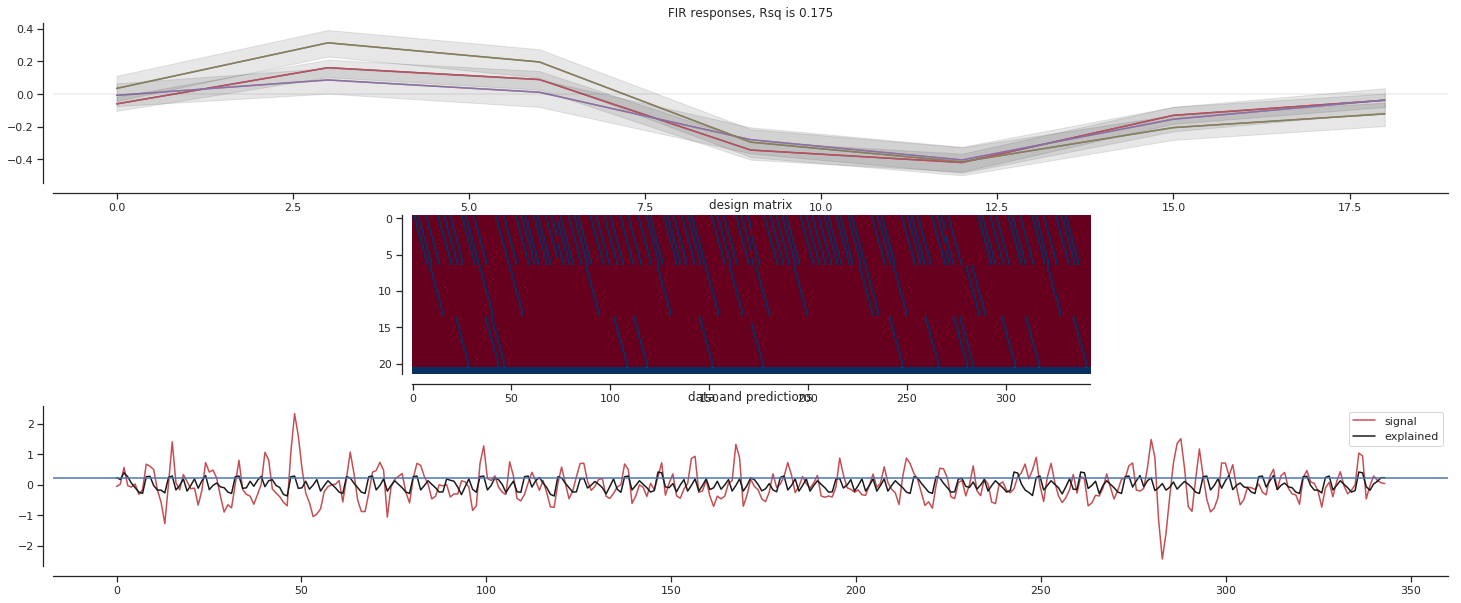

In [527]:
fd = fir_models['M1']['me'][1]
fd.bootstrap_on_residuals()
plot_time = 343
figwidth, figheight = 25, 10

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    plt.plot(fd.deconvolution_interval_timepoints, dec)

for i, beta in enumerate(fd.betas_per_event_type): #zip(range(fd.bootstrap_betas_per_event_type.shape[0]), [go_trial, successful_stop, failed_stop]):
    plt.plot(fd.deconvolution_interval_timepoints, beta)
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

    plt.fill_between(fd.deconvolution_interval_timepoints, 
                     mb - sb, 
                     mb + sb,
                     color = 'k',
                     alpha = 0.1)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')

s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
         fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.axhline(fd.betas[-1])
plt.legend(['signal','explained'])
sn.despine(offset=10)
plt.show()


In [591]:
def plot_overall_FIR2(fmodels, f=None, ax=None, baseline_kernels=False, include_rsq=False, as_pct_signal_change=False):

    if f is None and ax is None:
        f, ax = plt.subplots(1,1)
    
    all_evs = []
    for i, ev in enumerate(fmodels[0].event_names):
        all_evs.append(np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints))))        

        for sub, fir_model in enumerate(fmodels):
            all_evs[i][sub,:] = fir_model.betas_per_event_type[i,:,0] #- np.mean(fir_model.betas_per_event_type[0][0,0])
            if as_pct_signal_change:
                all_evs[i][sub,:] = (fir_model.betas_per_event_type[i,:,0]+fir_model.betas[-1])/fir_model.betas[-1]*100-100

#                all_evs[i][sub,:] = (fir_model.betas_per_event_type[i,:,0]+fir_model.betas[-1])
#                all_evs[i][sub,:] = (fir_model.betas_per_event_type[i,:,0]+fir_model.betas[-1])/(fir_model.betas[-1]+fir_model.betas_per_event_type[i,:3,0]).mean()*100-100
#                all_evs[i][sub,:] = (fir_model.betas_per_event_type[i,:,0])/(fir_model.betas_per_event_type[i,:3,0]).mean()*100-100

    if include_rsq:
        rsq = []
        for sub, fir_model in enumerate(fmodels):
            rsq.append(fir_model.rsq)
            
#     if baseline_kernels:
#         ### baseline kernels *over subjects*
#         baseline = all_evs[0][:,0].mean()
#         for i in range(len(all_evs)):
#             all_evs[i] = all_evs[i] - baseline
    
    ###
    for i in range(len(all_evs)):
        ax.plot(fir_model.deconvolution_interval_timepoints, all_evs[i].mean(0))

    # standard errors?
    for beta in all_evs: # [go_trials, successful_stops, failed_stops]:
        ax.fill_between(fir_model.deconvolution_interval_timepoints, 
                        beta.mean(0) - sp.stats.sem(beta, axis=0), 
                        beta.mean(0) + sp.stats.sem(beta, axis=0),
                        color = 'k',
                        alpha = 0.1)

    if include_rsq:
        plt.text(0.95, 0.95, '$R^2 = %.2f±%.2f$' %(np.mean(rsq), np.std(rsq)),
                 horizontalalignment='right',
                 verticalalignment='center',
                 transform = ax.transAxes)
    #axes[0].legend(['Go trial', 'Successful stop', 'Failed stop'])
    # sn.despine(offset=10)
    ax.axhline(0, lw=0.25, alpha=0.75, color = 'k')
#    return f, axes

In [ ]:
# gridspec = dict(width_ratios=[1, 1, 1, .1, 1])

# f, axes = plt.subplots(len(fir_models), 5, gridspec_kw=gridspec)  # plot masks x acquisitions, add column for Rsq
# # common labels
# ax = f.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
# ax.grid(False)
# ax.set_ylabel('% signal change')
# # ax.set_xlabel('Time from trial onset (s)')
# ax.yaxis.labelpad = 30

# # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
# ext = []
# #loop over the columns (j) and rows(i) to populate subplots
# for j in range(4):
#     # save the axes bounding boxes for later use
#     ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

# # make nice
# inv = f.transFigure.inverted()
# width_left = ext[0][0]+(ext[2][0]+ext[2][1]-ext[0][0])/2.
# left_center = inv.transform( (width_left, 1) )

# # set column spanning title 
# # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
# plt.figtext(left_center[0], .08, "Time from trial onset (s)", va="center", ha="center")

# # # loop the loop
# # for i, (mask, firs) in enumerate(fir_models.items()):
# #     plot_fixed_effects_fir_models(firs['se'], f, axes[i, 0], baseline_kernels=True, as_pct_signal_change=True)
# #     plot_fixed_effects_fir_models(firs['me'], f, axes[i, 1], baseline_kernels=True, as_pct_signal_change=True)
# #     plot_fixed_effects_fir_models(firs['me_denoised'], f, axes[i, 2], baseline_kernels=True, as_pct_signal_change=True)
# #     axes[i,0].set_ylabel('%s' %(mask))
    
# #     # get maximum ylims, set
# #     current_ranges = np.array([np.array(x.get_ylim()) for x in axes[i,:3]])
# #     for ax in axes[i,:3]:
# #         ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

# # loop the loop
# for i, (mask, firs) in enumerate(fir_models.items()):
#     plot_overall_FIR2(firs['se'], f, axes[i, 0], baseline_kernels=True, as_pct_signal_change=True)
#     plot_overall_FIR2(firs['me'], f, axes[i, 1], baseline_kernels=True, as_pct_signal_change=True)
#     plot_overall_FIR2(firs['me_denoised'], f, axes[i, 2], baseline_kernels=True, as_pct_signal_change=True)
#     axes[i,0].set_ylabel('%s' %(mask))
    
#     # get maximum ylims, set
#     current_ranges = np.array([np.array(x.get_ylim()) for x in axes[i,:3]])
#     for ax in axes[i,:3]:
#         ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])


# axes[0,2].legend(['Right response', 'Left response'], fontsize=10)  # not a super location for the legend...
# # axes[1,2].legend(['Go', 'SucStop', 'FailedStop'], fontsize=10)  # not a super location for the legend...
# axes[2,2].legend(['Go', 'SucStop', 'FailedStop'], fontsize=10)  # not a super location for the legend...

# mod=3
# f.set_size_inches(4*mod, len(fir_models)*mod)
# #plot_overall_FIR2()

In [712]:
def plot_overall_FIR(fmodels, f=None, ax=None, baseline_kernels=False, include_rsq=True):

    if f is None and ax is None:
        f, ax = plt.subplots(1,1)
    
    if isinstance(fmodels[0], list):
        # assume list of firmodels, each for one run
        # make a nSubs x nTimepoints x nRuns array
        go_trials = np.empty((len(fmodels), len(fmodels[0][0].deconvolution_interval_timepoints), len(fmodels[0])))
        successful_stops = np.empty((len(fmodels), len(fmodels[0][0].deconvolution_interval_timepoints), len(fmodels[0])))
        failed_stops = np.empty((len(fmodels), len(fmodels[0][0].deconvolution_interval_timepoints), len(fmodels[0])))
        
        for sub, fir_model_list in enumerate(fmodels):
            for run in range(len(fmodels[sub])):
                go_trials[sub,:,run] = fmodels[sub][run].betas_per_event_type[0][:,0]# + fmodels[sub][run].betas[-1]
                successful_stops[sub,:,run] = fmodels[sub][run].betas_per_event_type[1][:,0]# + fmodels[sub][run].betas[-1]
                failed_stops[sub,:,run] = fmodels[sub][run].betas_per_event_type[2][:,0]# + fmodels[sub][run].betas[-1]
        

        go_trials = go_trials.mean(2)
        successful_stops = successful_stops.mean(2)
        failed_stops = failed_stops.mean(2)
        fir_model = fir_model_list[0] # for plotting
    else:
        go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
        successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
        failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
        
        if include_rsq:
            rsq = []

        for sub, fir_model in enumerate(fmodels):
            go_trials[sub,:] = fir_model.betas_per_event_type[0,:,0] #- np.mean(fir_model.betas_per_event_type[0][0,0])
            successful_stops[sub,:] = fir_model.betas_per_event_type[1,:,0] #+ fir_model.betas[-1]# - np.mean(fir_model.betas_per_event_type[1][0,0])
            failed_stops[sub,:] = fir_model.betas_per_event_type[2,:,0] # + fir_model.betas[-1]# - np.mean(fir_model.betas_per_event_type[2][0,0])

            if include_rsq:
                rsq.append(fir_model.rsq)
            
    if baseline_kernels:
        ### baseline kernels *over subjects*
#         go_trials = go_trials - go_trials[:,0].mean()  # add mean at t=0
#         successful_stops = successful_stops - successful_stops[:,0].mean()  # add mean at t=0
#         failed_stops = failed_stops - failed_stops[:,0].mean()  # add mean at t=0
        # use go_trials as baseline
        baseline = go_trials[:,0].mean()
        go_trials = go_trials - baseline  # add mean at t=0
        successful_stops = successful_stops - baseline  # add mean at t=0
        failed_stops = failed_stops - baseline  # add mean at t=0
    
    ###
    ax.plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
    ax.plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
    ax.plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

    # standard errors?
    for beta in [go_trials, successful_stops, failed_stops]:
        ax.fill_between(fir_model.deconvolution_interval_timepoints, 
                             beta.mean(0) - sp.stats.sem(beta, axis=0), 
                             beta.mean(0) + sp.stats.sem(beta, axis=0),
                             color = 'k',
                             alpha = 0.1)

    if include_rsq:
        plt.text(0.95, 0.95, '$R^2 = %.2f±%.2f$' %(np.mean(rsq), np.std(rsq)),
                 horizontalalignment='right',
                 verticalalignment='center',
                 transform = ax.transAxes)
    #axes[0].legend(['Go trial', 'Successful stop', 'Failed stop'])
    # sn.despine(offset=10)
    ax.axhline(0, lw=0.25, alpha=0.75, color = 'k')
#    return f, axes

In [218]:
# plot_mask = 'PreSMA_R'
# fir_models_se = run_masks[plot_mask][0]
# fir_models_me = run_masks[plot_mask][1]
# fir_models_me_denoised = run_masks[plot_mask][2]

# f, axes = plt.subplots(3, len(run_masks))  # plot acquisition x masks
# # common labels
# ax = f.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
# ax.grid(False)
# ax.set_ylabel('% signal change')
# ax.set_xlabel('Time from trial onset (s)')
# ax.yaxis.labelpad = 30

# # loop the loop
# for i, (mask, fir_models) in enumerate(run_masks.items()):
#     plot_overall_FIR(fir_models[0], f, axes[0, i], baseline_kernels=True)
#     plot_overall_FIR(fir_models[1], f, axes[1, i], baseline_kernels=True)
#     plot_overall_FIR(fir_models[2], f, axes[2, i], baseline_kernels=True)

#     for ii in range(3):
#         axes[ii,i].set_ylim(-0.3, 0.7)
    
#     axes[0,i].set_title('%s' %mask)

# # hide ticks/values on axes
# for col in range(1, len(run_masks)):
#     axes[0,col].tick_params(top='off', right='off', labelbottom='Off', labelleft='Off')
#     axes[1,col].tick_params(top='off', right='off', labelbottom='Off', labelleft='Off')
#     axes[2,col].tick_params(top='off', left='off', right='off', labelleft='Off')
# axes[0,0].tick_params(top='off', right='off', labelbottom='Off')
# axes[1,0].tick_params(top='off', right='off', labelbottom='Off')

# # prettify
# axes[1,len(run_masks)-1].legend(['Go trial', 'Successful stop', 'Failed stop'], loc=6, bbox_to_anchor=(1.0, 0.0), ncol=1)
# axes[0,0].set_ylabel('Single Echo')
# axes[1,0].set_ylabel('Multi Echo')
# axes[2,0].set_ylabel('Multi Echo den.')
# #axes[ii,i].set_xlabel('Time from event onset (s)')

# sn.despine(offset=10)
# mod=3
# f.set_size_inches(7*mod, 3*mod)

### Analyze $R^2$

In [751]:
# add Rsq column
rsqs = []
for i, (mask, fir_models_by_seq) in enumerate(fir_models.items()):
    for sequence in range(3):
        seq_name = ['SE', 'ME', 'ME.den'][sequence]
        seq_name2 = ['se', 'me', 'me_denoised'][sequence]
        all_subs = [all_subs_se, all_subs_me, all_subs_me_denoised][sequence]
        for sub, fir_model in enumerate(fir_models_by_seq[seq_name2]):
            rsqs.append(pd.DataFrame({'sub': all_subs[sub], 'mask': mask, 
                                      'sequence': seq_name, 'rsq': fir_model.rsq}))
# concatenate all rsqs over sequences & models
rsq_df = pd.concat(rsqs)
rsq_df_piv = rsq_df.pivot_table(values='rsq', index='sub', columns=['sequence', 'mask'])

#### t-test 1: Was SE better than ME?

In [752]:
rsq_df_means = rsq_df.groupby(['sub', 'sequence'])['rsq'].mean().reset_index()
# remove sub 12: no ME measurement
rsq_df_means = rsq_df_means[rsq_df_means['sub'] != '12']
t_test_SE_ME = sp.stats.ttest_rel(rsq_df_means.loc[rsq_df_means.sequence=='SE', 'rsq'].values,
                                  rsq_df_means.loc[rsq_df_means.sequence=='ME', 'rsq'].values)
t_test_SE_ME

Ttest_relResult(statistic=3.80770407303473, pvalue=0.0015473767992318212)

Yes, $R^2$ is higher using the SE data than using the ME data

#### t-test 2: Was SE better than ME after denoising?

In [753]:
rsq_df_means = rsq_df.groupby(['sub', 'sequence'])['rsq'].mean().reset_index()
#remove sub 12
rsq_df_means = rsq_df_means[rsq_df_means['sub'] != '12']
sp.stats.ttest_rel(rsq_df_means.loc[rsq_df_means.sequence=='SE', 'rsq'].values,
                   rsq_df_means.loc[rsq_df_means.sequence=='ME.den', 'rsq'].values, nan_policy='omit')

Ttest_relResult(statistic=2.4338559908437434, pvalue=0.027031419486747605)

Yes, $R^2$ is higher using the SE data than using the denoised ME data

## plotting

In [732]:
def get_within_subject_sem(rsq_df, mask=None):
    # within-subject standard errors
    def nansem(values):
        from scipy import stats
        values = values[pd.notnull(values)]
        return stats.sem(values)
    
    rsq_df_tmp = rsq_df.copy()
    
    # select mask, if applicable
    if mask is not None:
        rsq_df_tmp = rsq_df_tmp.loc[rsq_df_tmp.mask == mask]
    
    rsq_df_tmp = rsq_df_tmp.pivot_table(values='rsq', index='sub', columns=['sequence'])

    # Cousineau (2005) method: subtract rowmeans, add global mean
    norowmeans = rsq_df_tmp.sub(rsq_df_tmp.mean(axis=1), axis=0)
    final_df = norowmeans.add(rsq_df_tmp.mean())

    # get SEM
    final_df = final_df.melt()
    return final_df.groupby(['sequence'])['value'].apply(lambda x: nansem(x))

In [733]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None,
                             ax=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    
    if ax is None:
        ax = plt.gca()
    
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

Ttest_relResult(statistic=3.3749395594194955, pvalue=0.0038588911507869642)
Ttest_relResult(statistic=0.7711726586492244, pvalue=0.4518436893448502)


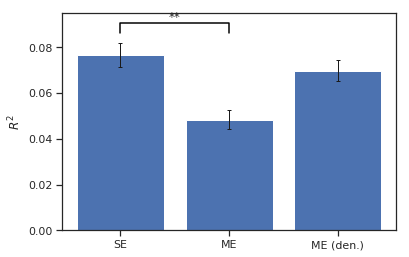

In [734]:
def make_barplot(rsq_df, 
                 names_map={'SE': 'SE', 'ME': 'ME', 'ME.den': 'ME (den.)'}, 
                 order=['SE', 'ME', 'ME (denoised)'], ax=None, include_tests=True):
    from scipy import stats
    means = rsq_df.groupby('sequence')['rsq'].mean()
    ses = get_within_subject_sem(rsq_df)
#     print(means)
#     print(ses)
    xs = ['SE', 'ME', 'ME (den.)']
    mns = [means['SE'], means['ME'], means['ME.den']]
    ses = [ses['SE'],ses['ME'], ses['ME.den']]
    
    if ax is None:
        f, ax  = plt.subplots(1,1)
    ax.bar(x=xs, height=mns)
    ax.errorbar(x=xs, y=mns, yerr=ses, ecolor='k', linewidth=1, ls='none', capsize=2)
    ax.set(ylabel='$R^2$')
    
    if include_tests:
        # tests for significance: SE vs ME
        rsq_df_means = rsq_df.groupby(['sub', 'sequence'])['rsq'].mean().reset_index()
        # remove sub 12
        rsq_df_means = rsq_df_means[rsq_df_means['sub'] != '12']
        t_test_se_me = sp.stats.ttest_rel(rsq_df_means.loc[rsq_df_means.sequence=='SE', 'rsq'].values,
                                          rsq_df_means.loc[rsq_df_means.sequence=='ME', 'rsq'].values, 
                                          nan_policy='omit')
        t_test_se_meden = sp.stats.ttest_rel(rsq_df_means.loc[rsq_df_means.sequence=='SE', 'rsq'].values,
                                             rsq_df_means.loc[rsq_df_means.sequence=='ME.den', 'rsq'].values, 
                                             nan_policy='omit')
        print(t_test_se_me)
        print(t_test_se_meden)

        first_sign = False
        if t_test_se_me[1] < 0.05:
            barplot_annotate_brackets(0, 1, t_test_se_me[1], [0,1,2], mns, ses, ax=ax)
            first_sign = True
        if t_test_se_meden[1] < 0.05:
            if first_sign:
                dh = 0.2
            else:
                dh = 0
            barplot_annotate_brackets(0, 2, t_test_se_meden[1], [0,1,2], mns, ses, dh=dh, ax=ax)
    
make_barplot(rsq_df=rsq_df.loc[rsq_df['mask']=='STN_R'].copy())

In [735]:
def fix_label(txt):
    return txt.replace("_L","").replace("_R","").replace("rIFG", "IFG")

In [737]:
# only plot STN, STR, IFG, preSMA, M1: pop GP
all_models = fir_models

fir_models.keys()
GPi_R = fir_models.pop('GPi_R')
GPe_R = fir_models.pop('GPe_R')
#M1_L = fir_models.pop('M1_L')
#STN_L = fir_models.pop('STN_L')
#PreSMA_L = fir_models.pop('PreSMA_L')
#GPi_L = fir_models.pop('GPi_L')
#GPe_L = fir_models.pop('GPe_L')
#M1 = fir_models.pop('M1')
#STR_L = fir_models.pop('STR_L')

KeyError: 'GPi_R'

In [738]:
fir_models = {
    'STN_R': fir_models["STN_R"],
    'STR_R': fir_models['STR_R'],
    'PreSMA_R': fir_models['PreSMA_R'],
    'rIFG': fir_models['rIFG'],
    'M1_R': fir_models['M1_R']
}

Ttest_relResult(statistic=3.3749395594194955, pvalue=0.0038588911507869642)
Ttest_relResult(statistic=0.7711726586492244, pvalue=0.4518436893448502)
Ttest_relResult(statistic=2.281631381449651, pvalue=0.03653999199324559)
Ttest_relResult(statistic=2.773051199100534, pvalue=0.013574761888057145)
Ttest_relResult(statistic=-0.9126102649950711, pvalue=0.37499416785624395)
Ttest_relResult(statistic=-2.752577603396493, pvalue=0.01415883597729144)
Ttest_relResult(statistic=2.1510487190808694, pvalue=0.04709699413425703)
Ttest_relResult(statistic=2.0999033797469426, pvalue=0.051950157344133614)
Ttest_relResult(statistic=-0.0672263639316311, pvalue=0.9472344096645413)
Ttest_relResult(statistic=0.3686453659511985, pvalue=0.7172244784129358)


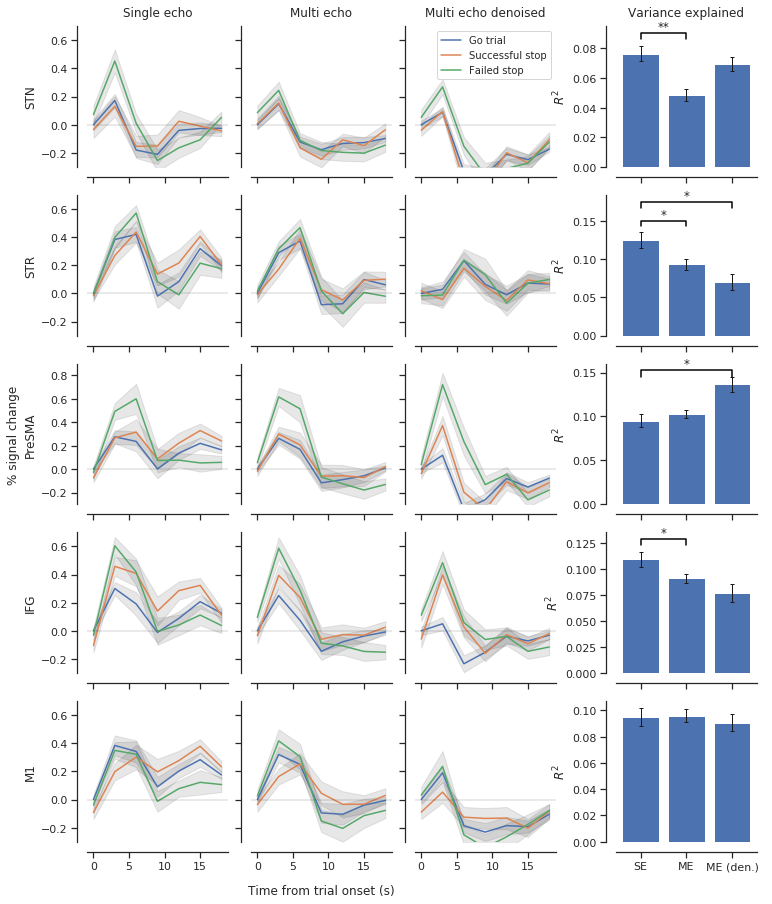

In [743]:
# plot_mask = 'M1'
# fir_models_se = run_masks[plot_mask][0]
# fir_models_me = run_masks[plot_mask][1]
# fir_models_me_denoised = run_masks[plot_mask][2]

gridspec = dict(width_ratios=[1, 1, 1, .1, 1])

f, axes = plt.subplots(len(fir_models), 5, gridspec_kw=gridspec)  # plot masks x acquisitions, add column for Rsq
# common labels
ax = f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.grid(False)
ax.set_ylabel('% signal change')
# ax.set_xlabel('Time from trial onset (s)')
ax.yaxis.labelpad = 30

# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(4):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[2][0]+ext[2][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .08, "Time from trial onset (s)", va="center", ha="center")

# loop the loop
for i, (mask, fir_models_by_seq) in enumerate(fir_models.items()):
    plot_overall_FIR(fir_models_by_seq['se'], f, axes[i, 0], baseline_kernels=True, include_rsq=False)
    plot_overall_FIR(fir_models_by_seq['me'], f, axes[i, 1], baseline_kernels=True, include_rsq=False)
    plot_overall_FIR(fir_models_by_seq['me_denoised'], f, axes[i, 2], baseline_kernels=True, include_rsq=False)

    for ii in range(3):
        axes[i,ii].set_ylim(-0.3, 0.7)
        if mask == 'PreSMA_R':
            # increase y limits for preSMA_R
            axes[i,ii].set_ylim(-0.3, 0.9)
    
    axes[i,0].set_ylabel('%s' %fix_label(mask))
#     sns.catplot(x='sequence', y='rsqdiff', data=rsq_diffs, kind='bar')
#     ax.set(ylabel = '$R^2$ difference', xlabel='')
    
    # add last col
    make_barplot(rsq_df.loc[rsq_df['mask']==mask].copy(), ax=axes[i,-1])
    
# turn off 4th column
for row in range(axes.shape[0]):
    axes[row,3].set_visible(False)

# hide ticks/values on axes
for col in range(1, 3):
    for row in range(0, len(fir_models)-1):
        axes[row,col].tick_params(top='off', right='off', labelbottom='Off', labelleft='Off')
        axes[row,col].tick_params(top='off', right='off', labelbottom='Off', labelleft='Off')
    
    axes[len(fir_models)-1,col].tick_params(top='off', right='off', labelleft='Off')

for row in range(0, len(fir_models)-1):
    axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
    axes[row,0].tick_params(top='off', right='off', labelbottom='Off')

## prettify
title_pads = 10
axes[0,0].set_title('Single echo', pad=title_pads)
axes[0,1].set_title('Multi echo', pad=title_pads)
axes[0,2].set_title('Multi echo denoised', pad=title_pads)
axes[0,4].set_title('Variance explained', pad=title_pads)
axes[0,2].legend(['Go trial', 'Successful stop', 'Failed stop'], fontsize=10)  # not a super location for the legend...
# axes[0,-1].set_ylim(0,.1) # extra space for title

sn.despine(offset=10)
mod=3
f.set_size_inches(4*mod, len(fir_models)*mod)
f.savefig('./deconvolution_new.pdf', bbox_inches='tight')

In [670]:
fir_models_by_seq['se'][0].betas_per_event_type[0,:,0]

array([ 0.14639376,  0.35961374,  0.12926741, -0.25697556, -0.36292477,
       -0.39043679, -0.23922617])

In [662]:
fir_models['STN_L']['se']

### Deconvolve Multi-Echo data (optcomb, not denoised)

In [12]:
# ### Multi-echo data, only combined (no denoising)
# fir_models_me = []

# for sub in all_subs_me:
#     cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_me-optcomb_%s.pkl' %(sub, mask_name))
#     mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)

#     if os.path.exists(cache_fn):
#         print('Reading from cache...')
#         with open(cache_fn, 'rb') as f:
#             tmp = pkl.load(f)
#     else:
#         print('Getting mean ts...')
#         # get data
#         bold_imgs = ['./data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
#                      './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-2_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub),
#                      './data/deriv/fmriprep/sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-3_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, sub)
#                     ]

#         tmp = create_single_timeseries(bold_imgs, mask=mask_img)
#         with open(cache_fn, 'wb') as f:
#             pkl.dump(tmp, f)

    
#     # get events
#     all_events = concat_event_data(sub, 'me')

#     events = [np.array([x for x in all_events.loc[(all_events.trial_type=='go_trial'), 'onset'].tolist()]),
#               np.array([x for x in all_events.loc[(all_events.trial_type=='successful_stop'), 'onset'].tolist()]),
#               np.array([x for x in all_events.loc[(all_events.trial_type=='failed_stop'), 'onset'].tolist()])
#              ]

#     durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
#                  'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
#                  'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
#                 }
    
#     ### Fir
#     fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
#                               events=events, 
#                               event_names = ('go_trial', 'successful_stop', 'failed_stop'),
#                               durations=durations,
#                               sample_frequency=sample_rate, 
#                               deconvolution_frequency=deconv_frequency, 
#                               deconvolution_interval=[0,interval],)

#     fd.create_design_matrix()
#     fd.regress()
# #     fd.ridge_regress(cv = 5, alphas = (0.1, 1, 10))
#     fd.betas_for_events()
#     fd.calculate_rsq()
#     fd.bootstrap_on_residuals(nr_repetitions=1000)
#     fir_models_me.append(fd)
# #     # get events
# #     all_events = concat_event_data(sub, 'me')
# #     events = [np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'onset'].tolist()]),
# #               np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'onset'].tolist()]),
# #               np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'onset'].tolist()])
# #              ]

# #     durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
# #                  'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
# #                  'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
# #                 }
    
# #     ### Fir
# #     fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
# #                               events=events, 
# #                               event_names=('go_trial', 'successful_stop', 'failed_stop'), 
# #                               durations=durations,
# #                               sample_frequency=sample_rate, 
# #                               deconvolution_frequency=deconv_frequency, 
# #                               deconvolution_interval=[0,interval],)

# #     fd.create_design_matrix()
# # #    fd.regress()
# #     fd.ridge_regress(cv = 10, alphas = np.logspace(-5, 1, 15))    
# #     fd.betas_for_events()
# #     fd.calculate_rsq()
# # #    fd.bootstrap_on_residuals(nr_repetitions=1000)
    
# #     go_trial = np.array(fd.betas_per_event_type[0]).ravel()
# #     successful_stop = np.array(fd.betas_per_event_type[1]).ravel()
# #     failed_stop = np.array(fd.betas_per_event_type[2]).ravel()

# #     # baseline the kernels:
# #     go_trial = go_trial - go_trial[0].mean()
# #     successful_stop = successful_stop - successful_stop[0].mean()
# #     failed_stop = failed_stop - failed_stop[0].mean()

# #     # plot:
# #     plot_time = 100
# #     figwidth, figheight = 14, 10

# #     f = plt.figure(figsize = (figwidth, figheight))
# #     s = f.add_subplot(311)
# #     s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
# # #     for dec in fd.betas_per_event_type.squeeze():
# # #         plt.plot(fd.deconvolution_interval_timepoints, dec)

# # #     for i, beta in zip(range(fd.bootstrap_betas_per_event_type.shape[0]), [go_trial, successful_stop, failed_stop]):
# # #         plt.plot(fd.deconvolution_interval_timepoints, beta)
# # #         mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
# # #         sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

# # #         plt.fill_between(fd.deconvolution_interval_timepoints, 
# # #                         beta - sb, 
# # #                         beta + sb,
# # #                         color = 'k',
# # #                         alpha = 0.1)    

# #     # fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# #     # working on a fix here....
# #     plt.legend(fd.covariates.keys())
# #     sn.despine(offset=10)

# #     plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
# #     s = f.add_subplot(312)
# #     s.set_title('design matrix')
# #     plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
# #     sn.despine(offset=10)

# #     s = f.add_subplot(313)
# #     s.set_title('data and predictions')
# #     plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
# #             fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
# #     plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
# #             fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
# #     plt.legend(['signal','explained'])
# #     sn.despine(offset=10)
# #     plt.show()
# #     fir_models_me.append(fd)

### Deconvolve tedana-denoised data

In [13]:
# ### Let's try the tedana-denoised data
# fir_models_metedana = []

# for sub in all_subs_me_denoised:
#     cache_fn = os.path.join(deconvolution_cache, 'sub-%s_meants_tedana-denoised_%s.pkl' %(sub, mask_name))
#     mask_img = './masks/final_masks_mni09a_1p6mm/%s_def-img.nii.gz' %(mask_name)

#     if os.path.exists(cache_fn):
#         print('Reading from cache...')
#         with open(cache_fn, 'rb') as f:
#             tmp = pkl.load(f)
#     else:
#         print('Getting mean ts...')
#         # get data
#         bold_imgs = ['./tedana_denoising/TED.sub-%s_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32/dn_ts_OC.nii'%(sub),
#                      './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-2_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32/dn_ts_OC.nii'%(sub),
#                      './tedana_denoising/TED.sub-%s_ses-me_task-stop_run-3_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32/dn_ts_OC.nii'%(sub)
#                     ]

#         tmp = create_single_timeseries(bold_imgs, mask=mask_img)
#         with open(cache_fn, 'wb') as f:
#             pkl.dump(tmp, f)
    
#     # get events
#     all_events = concat_event_data(sub, 'me')

#     events = [np.array([x for x in all_events.loc[(all_events.trial_type=='go_trial'), 'onset'].tolist()]),
#               np.array([x for x in all_events.loc[(all_events.trial_type=='successful_stop'), 'onset'].tolist()]),
#               np.array([x for x in all_events.loc[(all_events.trial_type=='failed_stop'), 'onset'].tolist()])
#              ]

#     durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
#                  'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
#                  'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
#                 }
    
#     ### Fir
#     fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
#                               events=events, 
#                               event_names = ('go_trial', 'successful_stop', 'failed_stop'),
#                               durations=durations,
#                               sample_frequency=sample_rate, 
#                               deconvolution_frequency=deconv_frequency, 
#                               deconvolution_interval=[0,interval],)

#     fd.create_design_matrix()
#     fd.regress()
# #     fd.ridge_regress(cv = 5, alphas = (0.1, 1, 10))
#     fd.betas_for_events()
#     fd.calculate_rsq()
#     fd.bootstrap_on_residuals(nr_repetitions=1000)
#     fir_models_metedana.append(fd)
# #     # get events
# #     all_events = concat_event_data(sub, 'me')
# #     events = [np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'onset'].tolist()]),
# #               np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'onset'].tolist()]),
# #               np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'onset'].tolist()])
# #              ]

# #     durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
# #                  'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
# #                  'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
# #                 }
    
# #     ### Fir
# #     fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
# #                               events=events, 
# #                               event_names=('go_trial', 'successful_stop', 'failed_stop'), 
# #                               durations=durations,
# #                               sample_frequency=sample_rate, 
# #                               deconvolution_frequency=deconv_frequency, 
# #                               deconvolution_interval=[0,interval],)

# #     fd.create_design_matrix()
# # #    fd.regress()
# #     fd.ridge_regress(cv = 10, alphas = np.logspace(-5, 1, 15))    
# #     fd.betas_for_events()
# #     fd.calculate_rsq()
# # #    fd.bootstrap_on_residuals(nr_repetitions=1000)
    
# #     go_trial = np.array(fd.betas_per_event_type[0]).ravel()
# #     successful_stop = np.array(fd.betas_per_event_type[1]).ravel()
# #     failed_stop = np.array(fd.betas_per_event_type[2]).ravel()

# #     # baseline the kernels:
# #     go_trial = go_trial - go_trial[0].mean()
# #     successful_stop = successful_stop - successful_stop[0].mean()
# #     failed_stop = failed_stop - failed_stop[0].mean()

# #     # plot:
# #     plot_time = 100
# #     figwidth, figheight = 14, 10

# #     f = plt.figure(figsize = (figwidth, figheight))
# #     s = f.add_subplot(311)
# #     s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
# # #     for dec in fd.betas_per_event_type.squeeze():
# # #         plt.plot(fd.deconvolution_interval_timepoints, dec)

# # #     for i, beta in zip(range(fd.bootstrap_betas_per_event_type.shape[0]), [go_trial, successful_stop, failed_stop]):
# # #         plt.plot(fd.deconvolution_interval_timepoints, beta)
# # #         mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
# # #         sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

# # #         plt.fill_between(fd.deconvolution_interval_timepoints, 
# # #                         beta - sb, 
# # #                         beta + sb,
# # #                         color = 'k',
# # #                         alpha = 0.1)    

# #     # fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# #     # working on a fix here....
# #     plt.legend(fd.covariates.keys())
# #     sn.despine(offset=10)

# #     plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
# #     s = f.add_subplot(312)
# #     s.set_title('design matrix')
# #     plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
# #     sn.despine(offset=10)

# #     s = f.add_subplot(313)
# #     s.set_title('data and predictions')
# #     plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
# #             fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
# #     plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
# #             fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
# #     plt.legend(['signal','explained'])
# #     sn.despine(offset=10)
# #     plt.show()
# #     fir_models_metedana.append(fd)

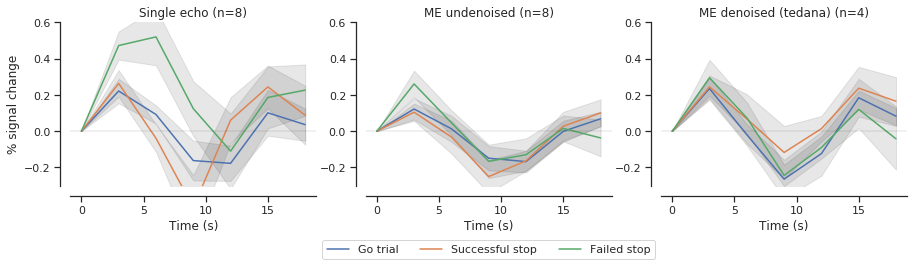

In [11]:
# ### Mean over subjects
# f, axes = plt.subplots(1, 3)

# fmodels = fir_models_se
# go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))

# for sub, fir_model in enumerate(fmodels):
#     go_trials[sub,:] = fir_model.betas_per_event_type[0][:,0] - np.mean(fir_model.betas_per_event_type[0][0,0])
#     successful_stops[sub,:] = fir_model.betas_per_event_type[1][:,0] - np.mean(fir_model.betas_per_event_type[1][0,0])
#     failed_stops[sub,:] = fir_model.betas_per_event_type[2][:,0] - np.mean(fir_model.betas_per_event_type[2][0,0])
    
# ###
# axes[0].plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
# axes[0].plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
# axes[0].plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

# # standard errors?
# for beta in [go_trials, successful_stops, failed_stops]:
#     axes[0].fill_between(fir_model.deconvolution_interval_timepoints, 
#                          beta.mean(0) - sp.stats.sem(beta, axis=0), 
#                          beta.mean(0) + sp.stats.sem(beta, axis=0),
#                          color = 'k',
#                          alpha = 0.1)

# #axes[0].legend(['Go trial', 'Successful stop', 'Failed stop'])
# # sn.despine(offset=10)
# axes[0].axhline(0, lw=0.25, alpha=0.5, color = 'k')
# axes[0].set_title('Single echo (n=%d)'%len(fmodels))


# ### Mean over subjects
# fmodels = fir_models_me
# go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))

# for sub, fir_model in enumerate(fmodels):
#     go_trials[sub,:] = fir_model.betas_per_event_type[0][:,0] - np.mean(fir_model.betas_per_event_type[0][0,0])
#     successful_stops[sub,:] = fir_model.betas_per_event_type[1][:,0] - np.mean(fir_model.betas_per_event_type[1][0,0])
#     failed_stops[sub,:] = fir_model.betas_per_event_type[2][:,0] - np.mean(fir_model.betas_per_event_type[2][0,0])
    
# ###
# axes[1].plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
# axes[1].plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
# axes[1].plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

# # standard errors?
# for beta in [go_trials, successful_stops, failed_stops]:
#     axes[1].fill_between(fir_model.deconvolution_interval_timepoints, 
#                      beta.mean(0) - sp.stats.sem(beta, axis=0), 
#                      beta.mean(0) + sp.stats.sem(beta, axis=0),
#                      color = 'k',
#                      alpha = 0.1)

# # axes[1].legend(['Go trial', 'Successful stop', 'Failed stop'])
# # sn.despine(offset=10)
# axes[1].axhline(0, lw=0.25, alpha=0.5, color = 'k')
# axes[1].set_title('ME undenoised (n=%d)'%len(fmodels))



# ### Mean over subjects
# fmodels = fir_models_metedana
# go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
# failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))

# for sub, fir_model in enumerate(fmodels):
#     go_trials[sub,:] = fir_model.betas_per_event_type[0][:,0] - np.mean(fir_model.betas_per_event_type[0][0,0])
#     successful_stops[sub,:] = fir_model.betas_per_event_type[1][:,0] - np.mean(fir_model.betas_per_event_type[1][0,0])
#     failed_stops[sub,:] = fir_model.betas_per_event_type[2][:,0] - np.mean(fir_model.betas_per_event_type[2][0,0])
    
# ###
# axes[2].plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
# axes[2].plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
# axes[2].plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

# # standard errors?
# for beta in [go_trials, successful_stops, failed_stops]:
#     axes[2].fill_between(fir_model.deconvolution_interval_timepoints, 
#                      beta.mean(0) - sp.stats.sem(beta, axis=0), 
#                      beta.mean(0) + sp.stats.sem(beta, axis=0),
#                      color = 'k',
#                      alpha = 0.1)

# axes[1].legend(['Go trial', 'Successful stop', 'Failed stop'], loc=9, bbox_to_anchor=(0.5, -0.3), ncol=3)
# axes[2].axhline(0, lw=0.25, alpha=0.5, color = 'k')
# axes[2].set_title('ME denoised (tedana) (n=%d)'%len(fmodels))

# for i in range(3):
#     axes[i].set_ylim(-0.3, 0.6)
#     axes[i].set_xlabel('Time (s)')
# axes[0].set_ylabel('% signal change')

# sn.despine(offset=10)
# f.set_size_inches(15, 3)

Text(0.5, 1.0, 'Mean BOLD-response after events (ME undenoised)')

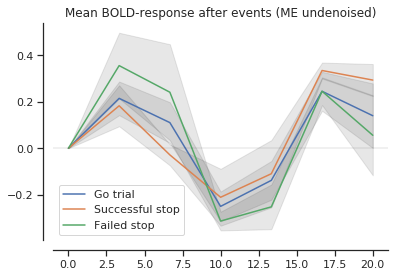

In [72]:
### Mean over subjects
fmodels = fir_models_me
go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))

for sub, fir_model in enumerate(fmodels):
    go_trials[sub,:] = fir_model.betas_per_event_type[0][:,0] - np.mean(fir_model.betas_per_event_type[0][0,0])
    successful_stops[sub,:] = fir_model.betas_per_event_type[1][:,0] - np.mean(fir_model.betas_per_event_type[1][0,0])
    failed_stops[sub,:] = fir_model.betas_per_event_type[2][:,0] - np.mean(fir_model.betas_per_event_type[2][0,0])
    
###
plt.plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
plt.plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
plt.plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

# standard errors?
for beta in [go_trials, successful_stops, failed_stops]:
    plt.fill_between(fir_model.deconvolution_interval_timepoints, 
                     beta.mean(0) - sp.stats.sem(beta, axis=0), 
                     beta.mean(0) + sp.stats.sem(beta, axis=0),
                     color = 'k',
                     alpha = 0.1)    

plt.legend(['Go trial', 'Successful stop', 'Failed stop'])
sn.despine(offset=10)
plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
plt.title('Mean BOLD-response after events (ME undenoised)')

Text(0.5, 1.0, 'Mean BOLD-response after events (tedana denoised)')

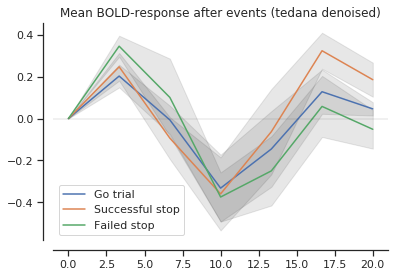

In [73]:
### Mean over subjects
fmodels = fir_models_metedana
go_trials = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
successful_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))
failed_stops = np.empty((len(fmodels), len(fmodels[0].deconvolution_interval_timepoints)))

for sub, fir_model in enumerate(fmodels):
    go_trials[sub,:] = fir_model.betas_per_event_type[0][:,0] - np.mean(fir_model.betas_per_event_type[0][0,0])
    successful_stops[sub,:] = fir_model.betas_per_event_type[1][:,0] - np.mean(fir_model.betas_per_event_type[1][0,0])
    failed_stops[sub,:] = fir_model.betas_per_event_type[2][:,0] - np.mean(fir_model.betas_per_event_type[2][0,0])
    
###
plt.plot(fir_model.deconvolution_interval_timepoints, go_trials.mean(0))
plt.plot(fir_model.deconvolution_interval_timepoints, successful_stops.mean(0))
plt.plot(fir_model.deconvolution_interval_timepoints, failed_stops.mean(0))

# standard errors?
for beta in [go_trials, successful_stops, failed_stops]:
    plt.fill_between(fir_model.deconvolution_interval_timepoints, 
                     beta.mean(0) - sp.stats.sem(beta, axis=0), 
                     beta.mean(0) + sp.stats.sem(beta, axis=0),
                     color = 'k',
                     alpha = 0.1)    

plt.legend(['Go trial', 'Successful stop', 'Failed stop'])
sn.despine(offset=10)
plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
plt.title('Mean BOLD-response after events (tedana denoised)')

In [41]:
all_events = concat_event_data(sub, 'se')
events = [np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'onset'].tolist()]),
          np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'onset'].tolist()]),
          np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'onset'].tolist()])
         ]

In [42]:
interval = 20  # BOLD response takes about 20 seconds
fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
                          events=events, 
                          event_names=('go_trial', 'successful_stop', 'failed_stop'), 
                          durations=durations,
                          sample_frequency=sample_rate, 
                          deconvolution_frequency=sample_rate, 
                          deconvolution_interval=[0,interval],)

fd.create_design_matrix()


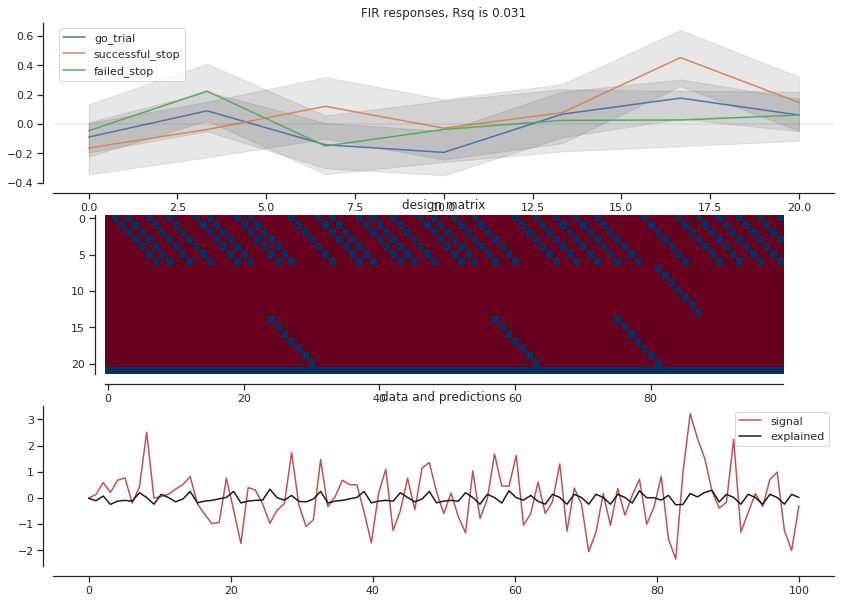

In [50]:
# perform the actual regression, in this case with the statsmodels backend
#fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
#fd.betas_for_events()

fd.calculate_rsq()

plot_time = 100
figwidth, figheight = 14, 10

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    plt.plot(fd.deconvolution_interval_timepoints, dec)

for i in range(fd.bootstrap_betas_per_event_type.shape[0]):
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)
   
    plt.fill_between(fd.deconvolution_interval_timepoints, 
                    mb - sb, 
                    mb + sb,
                    color = 'k',
                    alpha = 0.1)    
    
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
plt.legend(fd.covariates.keys())
sn.despine(offset=10)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.legend(['signal','explained'])
sn.despine(offset=10)


In [ ]:
# x = np.linspace(0, interval, len(go_trial))
# f = plt.figure(figsize = (10,3.5))

# plt.plot(x, go_trial, label='Go trial')
# plt.plot(x, successful_stop, label='Successful stop')
# plt.plot(x, failed_stop, label='Failed stop')
# plt.xlabel('Time from event (s)')
# plt.ylabel('Response (no idea what units, check this)')
# plt.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
# plt.legend(loc=2)

# fd.bootstrap_on_residuals(nr_repetitions=1000)
# for i in range(fd.bootstrap_betas_per_event_type.shape[0]):
#     mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
#     sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

#     plt.fill_between(fd.deconvolution_interval_timepoints, 
#                     mb - sb, 
#                     mb + sb,
#                     color = 'k',
#                     alpha = 0.1)
# plt.show()

In [ ]:
#     x = np.linspace(0, interval, len(go_trial))
#     f = pl.figure(figsize = (10,3.5))

#     pl.plot(x, go_trial, label='Go trial')
#     pl.plot(x, successful_stop, label='Successful stop')
#     pl.plot(x, failed_stop, label='Failed stop')
#     pl.xlabel('Time from event (s)')
#     pl.ylabel('Response (no idea what units, check this)')
#     pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
#     pl.legend(loc=2)

#     fd.bootstrap_on_residuals(nr_repetitions=1000)
#     for i in range(fd.bootstrap_betas_per_event_type.shape[0]):
#         mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
#         sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

#         pl.fill_between(fd.deconvolution_interval_timepoints, 
#                         mb - sb, 
#                         mb + sb,
#                         color = 'k',
#                         alpha = 0.1)
#     plt.show()

In [ ]:
go_trial.shape

In [ ]:
# anat_img = '/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz'
# bold_img = './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-3_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'

# def include(mask, threshold_percentile=.3):
#     def normalize(x):
#         x = np.asarray(x)
#         return (x - x.min()) / (np.ptp(x))
    
#     if not isinstance(mask, nib.Nifti1Image):
#         if isinstance(mask, str):
#             mask = nib.load(mask)
    
#     dat = mask.get_data()
#     dat_normalized = normalize(dat)
#     dat_include = np.array(dat_normalized>threshold_percentile, dtype=float)
    
#     img = nib.Nifti1Image(dat_include, mask.affine)
#     return img

# #plotting.plot_stat_map(include(mask_img, .3), bg_img=anat_img)
# masked_data = masking.apply_mask(bold_img, include(mask_img, .3))

In [ ]:
# masked_data_mean = masked_data.mean(1)

In [ ]:
# plt.plot(masked_data_mean)  # that is one serious trend

In [ ]:
# events[0]

In [ ]:
# timepoints = []
# time_delta_between_runs = 60  #seconds
# last_value = None
# n_pulses_per_run = (343, 343, 343)
# for i, run in enumerate(range(len(tmp))):
#     if i == 0:
#         start = 0
#         end = tmp[run].shape[0]*tr
#     else:
#         start = time_delta_between_runs*i + n_pulses_per_run[i-1]*tr*i
#         end = time_delta_between_runs*i + n_pulses_per_run[i-1]*tr*i + tr*n_pulses_per_run[i]
        
#     timepoints_this_run = np.arange(start, end, tr) #tmp[run].shape[0]*tr, step=tr)
    
#     timepoints.append(timepoints_this_run)

In [ ]:
# from scipy import stats

# tr = 3.
# # timepoints = [np.arange(tmp[0].shape[0]*tr, step=3),
# #               np.arange(tmp[1].shape[0]*tr, step=3)+50,
# #               np.arange(tmp[2].shape[0]*tr, step=3)+50]

# # high-pass filter 1/128
# sample_rate = 1/tr
# hp = 1/128.

# # High pass:
# hp_cof_sample = hp /  (sample_rate / 2)
# bhp, ahp = sp.signal.butter(3, hp_cof_sample, btype='highpass')
# data_highpass = sp.signal.filtfilt(bhp, ahp, masked_data_mean)  # this also demeans
# data_highpass = stats.zscore(data_highpass)

# f = plt.figure(figsize = (10,3.5))
# x = np.arange(timepoints.shape[0]) / sample_rate
# #pl.plot(x, masked_data_mean, label='orig')
# pl.plot(x, data_highpass, label='high pass')
# pl.xlabel('Time (s)')
# pl.ylabel('Signal')
# pl.legend()

# sn.despine(offset=10)

In [ ]:
# # get in events
# def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', event_types=('go_trial', 'successful_stop', 'failed_stop')):
#     import pandas

#     fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
#                       'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
#     df = pandas.read_csv(fn, sep='\t')

#     # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
#     # across subjects, we only look at correct trials
#     to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)

#     return to_return

# events = [np.array([x/tr for x in get_event_data('01', 'se', 1, event_types=['go_trial'])['onset'].tolist()]),
#           np.array([x/tr for x in get_event_data('01', 'se', 1, event_types=['successful_stop'])['onset'].tolist()]),
#           np.array([x/tr for x in get_event_data('01', 'se', 1, event_types=['failed_stop'])['onset'].tolist()])
#          ]

# # durations = {'go_trial': np.array([x/tr for x in get_onsets('01', 'se', 1, get_event_data=['go_trial'])['duration'].tolist()]),
# #              'successful_stop': np.array([x/tr for x in get_onsets('01', 'se', 1, get_event_data=['successful_stop'])['duration'].tolist()]),
# #              'failed_stop':np.array([x/tr for x in get_onsets('01', 'se', 1, get_event_data=['failed_stop'])['duration'].tolist()])
# #             }
# #events
# #plt.plot(events, [0 for x in range(len(events))], '.')
# # events = [(blink_ends / sample_rate), 
# #           (sac_ends / sample_rate)]


In [ ]:
interval = 25  # BOLD response takes about 20 seconds
fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
                          events=events, 
                          event_names=('go_trial', 'successful_stop', 'failed_stop'), 
                          durations=durations,
                          sample_frequency=sample_rate, 
                          deconvolution_frequency=sample_rate, 
                          deconvolution_interval=[0,interval],)

fd.create_design_matrix()
fd.regress()
fd.betas_for_events()
go_trial = np.array(fd.betas_per_event_type[0]).ravel()
successful_stop = np.array(fd.betas_per_event_type[1]).ravel()
failed_stop = np.array(fd.betas_per_event_type[2]).ravel()

# baseline the kernels:
go_trial = go_trial - go_trial[0].mean()
successful_stop = successful_stop - successful_stop[0].mean()
failed_stop = failed_stop - failed_stop[0].mean()

# plot:
x = np.linspace(0, interval, len(go_response))

f = pl.figure(figsize = (10,3.5))

pl.plot(x, go_trial, label='Go trial')
pl.plot(x, successful_stop, label='Successful stop')
pl.plot(x, failed_stop, label='Failed stop')
pl.xlabel('Time from event (s)')
pl.ylabel('Response (no idea what units, check this)')
pl.axhline(0,color = 'k', lw = 0.5, alpha = 0.5)
pl.legend(loc=2)

fd.bootstrap_on_residuals(nr_repetitions=1000)
for i in range(fd.bootstrap_betas_per_event_type.shape[0]):
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)
   
    pl.fill_between(fd.deconvolution_interval_timepoints, 
                    mb - sb, 
                    mb + sb,
                    color = 'k',
                    alpha = 0.1)